In [1]:
# Import modules
import pandas as pd
from transformers import pipeline, AutoTokenizer, TFAutoModelForSeq2SeqLM
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

/mnt/c/Users/kpali/Documents/Projects/Investment-Analytics-Data-Warehouse/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-06-08 11:53:59.470956: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-08 11:54:01.215445: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-08 11:54:02.704038: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749354844.044346  356882 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 

In [2]:
# Create pipeline
finbert = pipeline("text-classification", model="ProsusAI/finbert", return_all_scores=True, truncation=True)

2025-06-08 11:55:14.179230: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2025-06-08 11:55:14.383356: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 93763584 exceeds 10% of free system memory.
2025-06-08 11:55:14.509025: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 93763584 exceeds 10% of free system memory.
2025-06-08 11:55:14.561897: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 93763584 exceeds 10% of free system memory.
2025-06-08 11:55:17.298914: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 93763584 exceeds 10% of free system memory.
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are n

In [3]:
# Load the dataset
df = pd.read_json('reddit_sentiment.json', orient='records')
df.head()

,submission_id,submission_title,submission_utc,submission_body,comment_id,comment_body,comment_utc
0,1l50yhu,Whats going on with quantum stocks?,1749237530,What's going on with quantum computing stocks ...,mwdbz37,Everything is on pump for no real reason. Give...,1749238151
1,1l50yhu,Whats going on with quantum stocks?,1749237530,What's going on with quantum computing stocks ...,mwdci55,The market is quick to jump back into pretty m...,1749238313
2,1l50yhu,Whats going on with quantum stocks?,1749237530,What's going on with quantum computing stocks ...,mwdawu2,I own a couple hunded ionq i’ll let em roll,1749237831
3,1l50yhu,Whats going on with quantum stocks?,1749237530,What's going on with quantum computing stocks ...,mwdfza0,AI stocks are my largest money makers this yea...,1749239377
4,1l50yhu,Whats going on with quantum stocks?,1749237530,What's going on with quantum computing stocks ...,mwdgfe6,All 4 are just memes and vibes. There’s no met...,1749239514


In [4]:
# Covert date format to datetime and eastern timezone
df['submission_datetime'] = pd.to_datetime(df['submission_utc'], unit='s', utc=True)
df['submission_datetime'] = df['submission_datetime'].dt.tz_convert('America/New_York')
df['comment_datetime'] = pd.to_datetime(df['comment_utc'], unit='s', utc=True)
df['comment_datetime'] = df['comment_datetime'].dt.tz_convert('America/New_York')

In [5]:
# Retrieve minimim and maximum dates for submission_datetime
min_date = df['submission_datetime'].min()
max_date = df['submission_datetime'].max()
print(f"Minimum date: {min_date}")
print(f"Maximum date: {max_date}")

Minimum date: 2025-04-21 15:23:44-04:00
Maximum date: 2025-06-06 15:18:50-04:00


In [6]:
'''# Detect whether the submission_title, body, or comments have a saracastic tone
model_name = "mrm8488/t5-base-finetuned-sarcasm-twitter"

tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_name)

sarcasm_detector = pipeline("text2text-generation", model=model, tokenizer=tokenizer, framework="tf")

# Function to detect sarcasm
def detect_sarcasm(texts, batch_size=32):
    results = sarcasm_detector(texts, max_length=3, batch_size=batch_size)
    return [r['generated_text'].strip().lower() == 'derision' for r in results]

# Apply sarcasm detection to the submission title, body, and comments
#df['title_sarcasm'] = detect_sarcasm(df['submission_title'].tolist())
df['comments_sarcasm'] = detect_sarcasm(df['comment_body'].tolist())
df2['comments_sarcasm'] = detect_sarcasm(df2['comment_body'].tolist())

# df_filtered = df[~df['title_sarcasm'] & ~df['comments_sarcasm']].copy()'''

'# Detect whether the submission_title, body, or comments have a saracastic tone\nmodel_name = "mrm8488/t5-base-finetuned-sarcasm-twitter"\n\ntokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)\nmodel = TFAutoModelForSeq2SeqLM.from_pretrained(model_name)\n\nsarcasm_detector = pipeline("text2text-generation", model=model, tokenizer=tokenizer, framework="tf")\n\n# Function to detect sarcasm\ndef detect_sarcasm(texts, batch_size=32):\n    results = sarcasm_detector(texts, max_length=3, batch_size=batch_size)\n    return [r[\'generated_text\'].strip().lower() == \'derision\' for r in results]\n\n# Apply sarcasm detection to the submission title, body, and comments\n#df[\'title_sarcasm\'] = detect_sarcasm(df[\'submission_title\'].tolist())\ndf[\'comments_sarcasm\'] = detect_sarcasm(df[\'comment_body\'].tolist())\ndf2[\'comments_sarcasm\'] = detect_sarcasm(df2[\'comment_body\'].tolist())\n\n# df_filtered = df[~df[\'title_sarcasm\'] & ~df[\'comments_sarcasm\']].copy()'

In [7]:
# Number of submission bodies which are not null
num_submissions = df['submission_body'].notnull().sum()
print(f"Number of submission bodies which are not null: {num_submissions}")
# Number of comments which are not null
num_comments = df['comment_body'].notnull().sum()
print(f"Number of comments which are not null: {num_comments}")

Number of submission bodies which are not null: 130573
Number of comments which are not null: 130573


In [8]:
# Remove records which have null values for submission_body or comment_body
df_filtered = df.dropna(subset=['submission_body', 'comment_body', 'submission_title'])

In [9]:
# Filter dataframe for only first 20,000 rows
df_filtered = df.head(20000).copy()

In [10]:
# Function to calculate sentiment score from model output
def calculate_sentiment_score_batch(batch_outputs):
    scores = []
    for result in batch_outputs:
        sentiment_dict = {item['label'].lower(): item['score'] for item in result}
        score = (
            sentiment_dict.get('positive', 0) * 1.0 +
            sentiment_dict.get('neutral', 0) * 0.5 +
            sentiment_dict.get('negative', 0) * 0.0
        )
        scores.append(score)
    return scores

# Function to process in chunks
def process_in_batches(df, text_column, batch_size=500):
    sentiment_scores = []
    for start in range(0, len(df), batch_size):
        end = start + batch_size
        texts = df[text_column].iloc[start:end].fillna("").astype(str).tolist()
        batch_outputs = finbert(texts, truncation=True, max_length=512)
        batch_scores = calculate_sentiment_score_batch(batch_outputs)
        sentiment_scores.extend(batch_scores)
    return sentiment_scores

# Apply sentiment scoring in batches
df_filtered['submission_title_sentiment_score'] = process_in_batches(df_filtered, 'submission_title')
df_filtered['submission_body_sentiment_score'] = process_in_batches(df_filtered, 'submission_body')
df_filtered['comment_sentiment_score'] = process_in_batches(df_filtered, 'comment_body')

2025-06-08 13:01:10.730121: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 12582912 exceeds 10% of free system memory.


In [11]:
# Save to CSV as calculating sentiment scores can take a while
df_filtered.to_csv('reddit_sentiment_scores.csv', index=False)

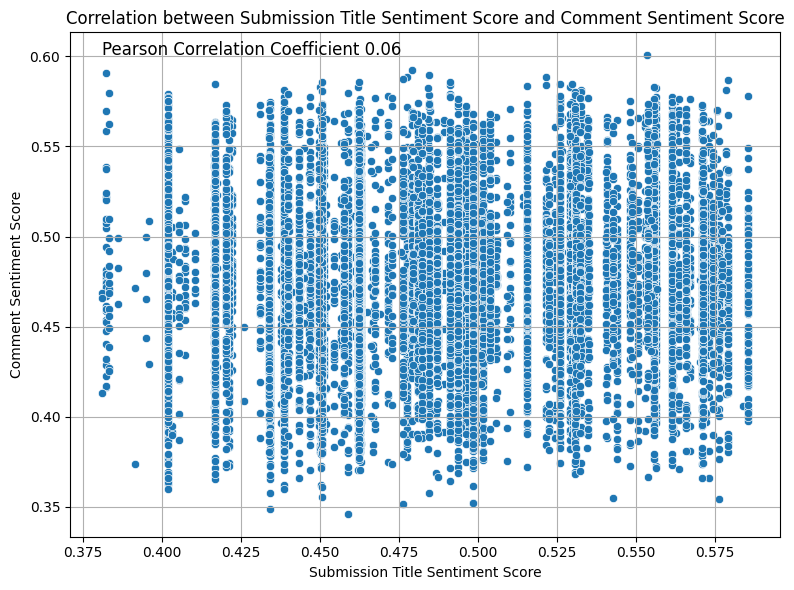

In [19]:
# Creation a correlation plot between submission_title_sentiment_score and comment_sentiment_score
x = df_filtered['submission_title_sentiment_score']
y = df_filtered['comment_sentiment_score']

# Compute Pearson correlation
r, _ = pearsonr(x, y)

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=x, y=y)
plt.title('Correlation between Submission Title Sentiment Score and Comment Sentiment Score')
plt.text(min(x), max(y), f"Pearson Correlation Coefficient {r:.2f}", fontsize=12)
plt.xlabel('Submission Title Sentiment Score')
plt.ylabel('Comment Sentiment Score')
plt.grid(True)
plt.tight_layout()
plt.show()

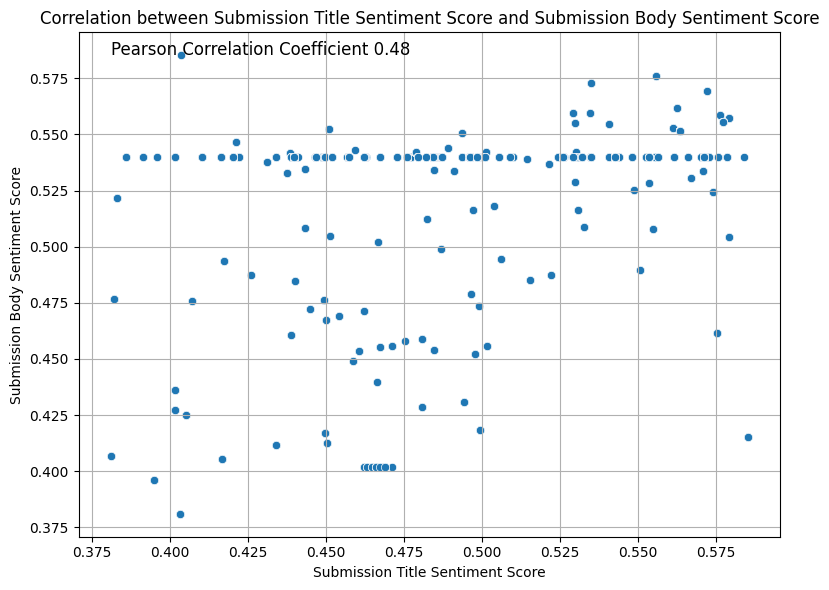

In [20]:
# Creation a correlation plot between submission_title_sentiment_score and submission_body_sentiment_score
x = df_filtered['submission_title_sentiment_score']
y = df_filtered['submission_body_sentiment_score']

# Compute Pearson correlation
r, _ = pearsonr(x, y)

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=x, y=y)
plt.title('Correlation between Submission Title Sentiment Score and Submission Body Sentiment Score')
plt.text(min(x), max(y), f"Pearson Correlation Coefficient {r:.2f}", fontsize=12)
plt.xlabel('Submission Title Sentiment Score')
plt.ylabel('Submission Body Sentiment Score')
plt.grid(True)
plt.tight_layout()
plt.show()

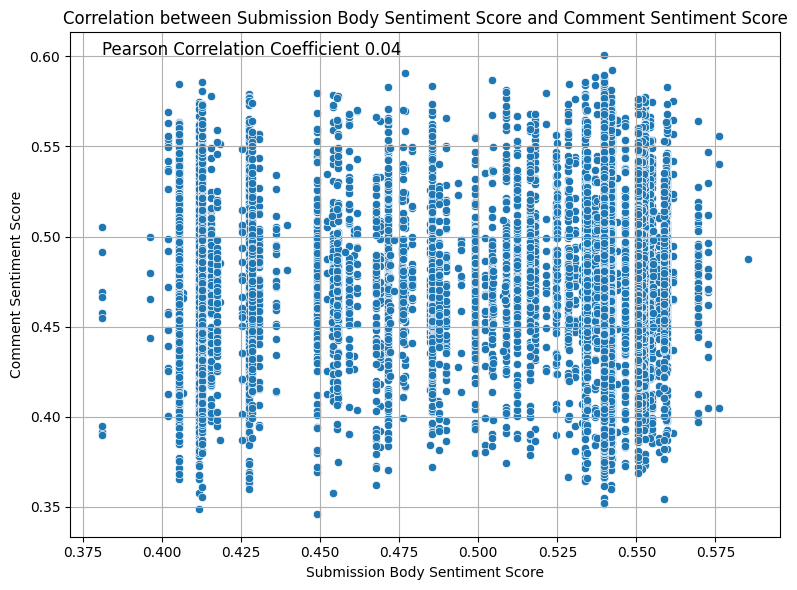

In [ ]:
# Creation of a correlation plot between submission_body_sentiment_score and comment_sentiment_score
x = df_filtered['submission_body_sentiment_score']
y = df_filtered['comment_sentiment_score']
# Compute Pearson correlation
r, _ = pearsonr(x, y)

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=x, y=y)
plt.title('Correlation between Submission Body Sentiment Score and Comment Sentiment Score')
plt.text(min(x), max(y), f"Pearson Correlation Coefficient {r:.2f}", fontsize=12)
plt.xlabel('Submission Body Sentiment Score')
plt.ylabel('Comment Sentiment Score')
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
# Analyse the distribution of submission_title_sentiment_score and comment_sentiment_score
df_filtered[['submission_title_sentiment_score','comment_sentiment_score', 'submission_body_sentiment_score']].describe()

,submission_title_sentiment_score,comment_sentiment_score,submission_body_sentiment_score
count,20000.000000,20000.000000,20000.000000
mean,0.480796,0.473673,0.510380
std,0.050583,0.037283,0.050555
min,0.381048,0.346219,0.381062
25%,0.438581,0.451649,0.476139
50%,0.477318,0.473477,0.539775
75%,0.525838,0.494848,0.539775
max,0.585291,0.600576,0.585235


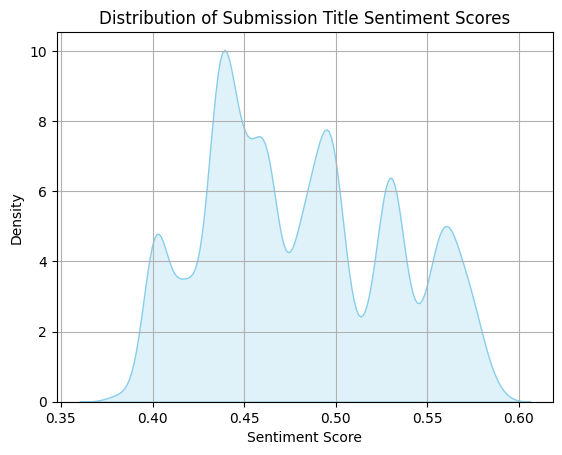

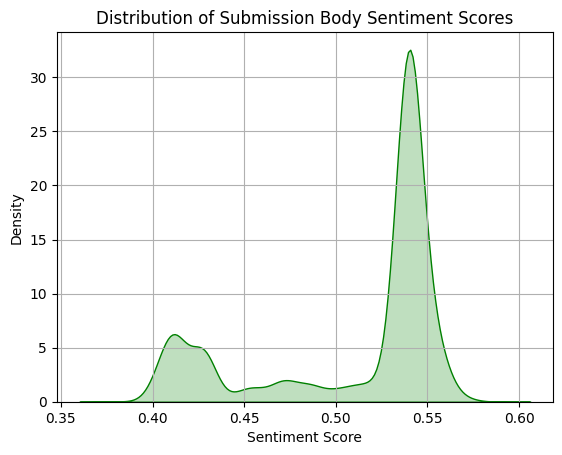

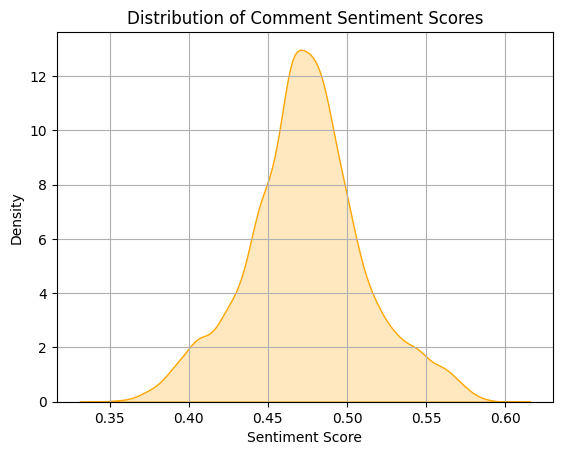

In [16]:
# Title Sentiment Distribution
sns.kdeplot(df_filtered['submission_title_sentiment_score'], fill=True, color='skyblue')
plt.title("Distribution of Submission Title Sentiment Scores")
plt.xlabel("Sentiment Score")
plt.ylabel("Density")
plt.grid(True)
plt.show()

# Body Sentiment Distribution
sns.kdeplot(df_filtered['submission_body_sentiment_score'], fill=True, color='green')
plt.title("Distribution of Submission Body Sentiment Scores")
plt.xlabel("Sentiment Score")
plt.ylabel("Density")
plt.grid(True)
plt.show()

# Comment Sentiment Distribution
sns.kdeplot(df_filtered['comment_sentiment_score'], fill=True, color='orange')
plt.title("Distribution of Comment Sentiment Scores")
plt.xlabel("Sentiment Score")
plt.ylabel("Density")
plt.grid(True)
plt.show()

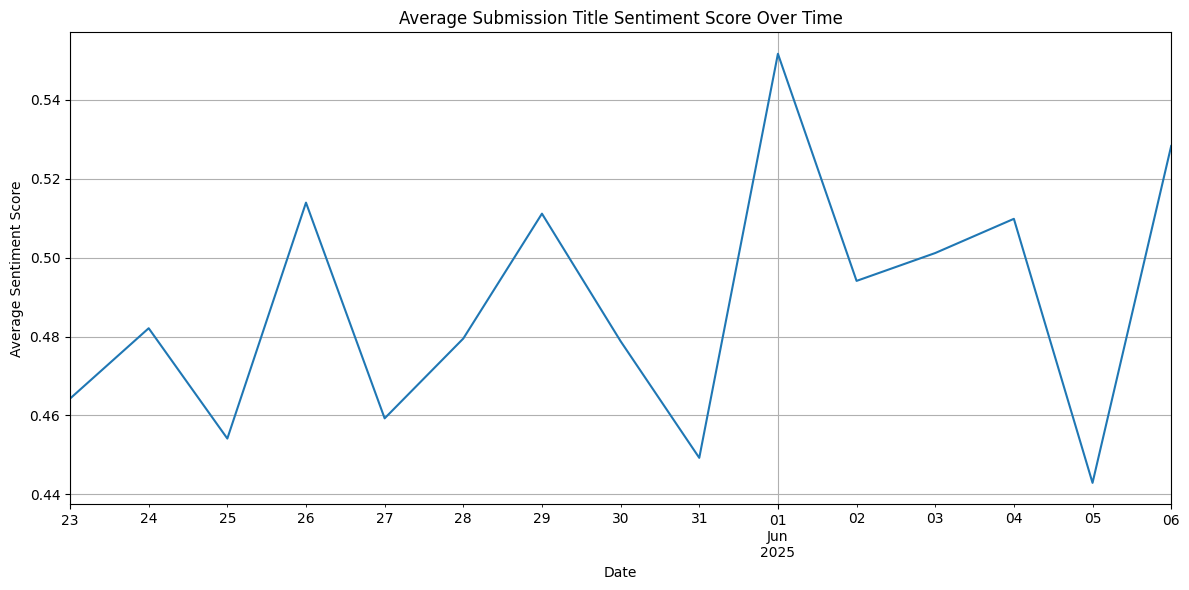

In [22]:
# Plot a line graph of submission_title_sentiment_score over time
plt.figure(figsize=(12, 6))
df_filtered.set_index('submission_datetime')['submission_title_sentiment_score'].resample('D').mean().plot()
plt.title('Average Submission Title Sentiment Score Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.grid(True)
plt.tight_layout()
plt.show()